# Categorical Encoding

<p style="text-align: justify">  
Unsupervised learning problems such as anomaly detection and clustering are challenging due to lack of labels required for training embeddings and validating the results. Therefore, it becomes essential to use the right encoding schemes, dimensionality reduction methods, and models. In these type of learning problems, manipulating numerical variables is straightforwad as they can be easily plugged into statistical methods. For example, it is easy to find mean and standard deviations in the height of a population.
    
Categorical variables need to be handled carefully as they have to be converted to numbers. Ordinal categorical variables have an inherent ordering from one extreme to the other, for e.g., sentiment can be very negative, negative, neutral, positive, and very positive. We can use simple integer encoding or contrast encoding for these variables. 

In this notebook, we focus on encoding schemes for nominal categorical variables. These variables are particularly challenging because there is no inherent ordering in the variables, for e.g., weather can be rainy, sunny, snowy, etc. Encoding to numbers is challenging because we don't want to distort the distances between the levels of the variables. In other words, if we encode rainy as 0, sunny as 1, and snowy as 2 then the model will interpret rainy to be closer to sunny than snowy which is not true. A common approach is to use one-hot encoding scheme. The method works well because all the one hot vectors are orthogonal to each other preserving the true distances. However, when the cardinality of the variables increase, one-hot encoding explodes the computation. For example, if we have 1000 different types of weather conditions then one-hot would give a 1000 dimension vector. To improve performance, we may choose to reduce dimensions using various forms matrix decomposition techniques. However, since we cannot go back to original dimensional space, we lose explainability in this process. Therefore, we search for encoders that optimally balance the trade-off between performance and explainability.
</p>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os, sys
sys.path.insert(0, os.path.realpath(os.path.pardir))
from string_categorical_encoders.column_encoder import ColumnEncoder #This is where the magic happens
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
import category_encoders as ce
import pandas as pd
import numpy as np

<img src="../data/approach.png">

## Data
* To demonstrate different encoding techniques, we take a dataset with different employment position titles and their corresponding remuneration.
* The task is to predict using the position title, whether or not the employee earns more than 100k

In [2]:
# Data downloaded from here: https://opendata.vancouver.ca/explore/dataset/employee-remuneration-and-expenses-earning-over-75000/export/?disjunctive.department&disjunctive.title&sort=year
emp_df = pd.read_csv('../data/employee.csv', sep=';')[['Title', 'Remuneration']]
emp_df['Remuneration_class'] = emp_df['Remuneration'].apply(lambda x: x > 100000)
emp_df.drop('Remuneration', axis=1, inplace=True)
emp_df

,Title,Remuneration_class
0,Fire Captain,True
1,Trades Ii - Gardener,False
2,Corporate Compliance Analyst,False
3,Telecommunications Plant Coordinator,False
4,Civil Engineer I,False
...,...,...
25323,Firefighter,False
25324,Financial Analyst I,False
25325,Fire Prevention Inspector,False
25326,Firefighter,False


### Split into train and test

In [3]:
X = emp_df['Title']
y = emp_df['Remuneration_class']
X_col = ['Title']

In [4]:
def test_train_split(X, y, test_size=0.33, random_state=1):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    sss.get_n_splits(X, y)
    for train_index, test_index in sss.split(X, y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = test_train_split(X, y)
sample_X_train, sample_y_train, sample_X_test, sample_y_test = X_train, y_train, X_test, y_test

## Experiments

In [5]:
def experiments(encoder, dim_red=None):
    model=LGBMClassifier(is_unbalance='True')
    if dim_red:
        pipeline = Pipeline([
        ('enc', encoder),
        ('dim_red', dim_red),
        ('clf', model)
         ])
    else:
        pipeline = Pipeline([
        ('enc', encoder),
        ('clf', model)
         ])
    pipeline.fit(sample_X_train, sample_y_train)
    pred = pipeline.predict(sample_X_test)
    return(pipeline,
           classification_report(sample_y_test, pred),
           f1_score(sample_y_test, pred, average='weighted')
          )
        

## Encoders


### Integer Encoder

* Process
    * Base: N
    * Convert categories to integers
    * For example, all Civil Engineer I will be represented by integer k
* Pros
    * Easy to implement and use
    * Least number of output vector dimensions
* Cons
    * Usually a poor choice as it adds random ordinality. In other words, the distances between categories are distorted which can give unreliable results


In [6]:
preprocessor = ColumnEncoder('OrdinalEncoder')
pipe_ie, report_ie, f1_ie = experiments(preprocessor)
print(report_ie)

              precision    recall  f1-score   support

       False       0.80      0.72      0.76      5214
        True       0.60      0.70      0.65      3145

    accuracy                           0.71      8359
   macro avg       0.70      0.71      0.70      8359
weighted avg       0.73      0.71      0.72      8359



### Binary Encoder

* Process
    * Base: 2
    * First, encode the categories as integers
    * Convert integers into binary code
    * Split digits from that binary string into separate feature columns

* Pros
    * Encodes the data in relatively fewer dimensions
* Cons
    * There is still some distortion of distances between categories
    * Inverse mapping wouldn’t be perfect
    * For e.g., if we have four categories: 00, 01, 10, 11 then we have two features. If first feature is 0 it could mean both 00, and 01


In [7]:
preprocessor = ColumnEncoder('BinaryEncoder')
pipe_be, report_be, f1_be = experiments(preprocessor)
print(report_be)

              precision    recall  f1-score   support

       False       0.83      0.76      0.79      5214
        True       0.65      0.74      0.69      3145

    accuracy                           0.75      8359
   macro avg       0.74      0.75      0.74      8359
weighted avg       0.76      0.75      0.76      8359



### One Hot Encoder

* Process
    * Base: 1
    * Create one column per category 
    * Mark it 1 if the category is present in the row, 0 if it is not

* Pros
    * Does not distort distance between the categories
* Cons
    * Results in a very high dimension that is difficult to manipulate


In [8]:
preprocessor = ColumnEncoder('OneHotEncoder')
pipe_ohe, report_ohe, f1_ohe = experiments(preprocessor)
print(report_ohe)

              precision    recall  f1-score   support

       False       0.83      0.63      0.71      5214
        True       0.56      0.79      0.66      3145

    accuracy                           0.69      8359
   macro avg       0.70      0.71      0.69      8359
weighted avg       0.73      0.69      0.69      8359



### Hashing Encoder

This encoder uses the hashing trick to represent a high dimension space in a low dimension space while preserving sparsity. 

* Process
    * Convert variable to string “variable=category”, e.g., “modelname=Intel”
    * Convert this string to an integer using a hashing function
    * Modulo this integer by length of output vector required
    * Use that index for indicator 1 (Essentially one hot encoding in lower dimension)
* Pros
    * Fast and saves memory as lower dimension
    * Can use it for multiple categorical variables at the same time

* Cons
    * Collisions happen if the output vector size is small
    * No inverse mapping so no interpretation


In [9]:
preprocessor = ce.HashingEncoder()
pipe_he, report_he, f1_he = experiments(preprocessor)
print(report_he)

              precision    recall  f1-score   support

       False       0.67      0.55      0.60      5214
        True       0.42      0.55      0.48      3145

    accuracy                           0.55      8359
   macro avg       0.55      0.55      0.54      8359
weighted avg       0.58      0.55      0.56      8359



### Word Based
#### Similarity Encoder

* Process
    * Create one column per category
    * Define n-gram similarity 
    * For each category, compare similarity with other categories
    * Instead of 0 and 1 in one hot encoding use similarity value
    * E.g. Categories: Associate Software Developer, Software Developer, Senior Software Developer

* Pros
    * In high cardinality categorical variables different entries are often variations on the same entities
    * Using simple one-hot encoding will create orthogonal features, whereas it is clear that those 3 terms have a lot in common.
    * If we wanted to use word embedding methods such as word2vec, we would have to go through a cleaning phase: those algorithms are not trained to work on data such as ‘Accountant/Auditor I’. However, this can be error prone and time consuming.
    * The high dimensions can be meaningfully reduced to lower dimensions: All the categories in the above example to the category Software developer.

* Cons
    * High dimensionial output vector


In [11]:
preprocessor = ColumnEncoder('SimilarityEncoder')
pipe_se, report_se, f1_se = experiments(preprocessor)
print(report_se)

              precision    recall  f1-score   support

       False       0.85      0.82      0.83      5214
        True       0.71      0.76      0.74      3145

    accuracy                           0.79      8359
   macro avg       0.78      0.79      0.78      8359
weighted avg       0.80      0.79      0.80      8359



### Fasttext Encoder

* Process
    * Downloads a pretrained model on English words
    * For each category, performs a forward run of the pretrained model
    * Outputs the vectors from last layer of the model

* Pros
    * Dynamic length of output vector
    * Captures meaning in the words or categories

* Cons
    * Heavy file size of the pretrained model
    * May not work well with words that don't appear a lot in natural English
    * Output vector dimensions have no explainability


In [12]:
# To run this cell, we have to download
# 7.4g pretrained fastext model
# If you have sufficient resources,
# run the following commands to get it in the right place
# wget -P notebooks/data https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
# gunzip notebooks/data/cc.en.300.bin.gz

preprocessor = ColumnEncoder('PretrainedFastText')
pipe_ft, report_ft, f1_ft = experiments(preprocessor)
print(report_ft)

              precision    recall  f1-score   support

       False       0.85      0.81      0.83      5214
        True       0.71      0.76      0.73      3145

    accuracy                           0.79      8359
   macro avg       0.78      0.79      0.78      8359
weighted avg       0.80      0.79      0.79      8359



### Online Gamma Poisson Factorization [(paper)](https://arxiv.org/pdf/1907.01860.pdf)
* Process
    * Estimates a decomposition of the string entries in terms of a linear combination of latent categories.
    * Similar to LDA for finding topics in documents but since the string entries here are much shorter than text documents and can contain typos, it uses ngrams level representation.

* Pros
    * Low number of dimensions
    * The reduced dimensions can be interpreted as a combination of topic words and hence it has some degree of interpretability
* Cons
    * Works only with variables that have meaningful substring overlaps 
    * The interpretations are probabilistic


In [13]:
preprocessor = ColumnEncoder('OnlineGammaPoissonFactorization', ngram_range=(2, 4), n_components=10)
pipe_ogpf, report_ogpf, f1_ogpf = experiments(preprocessor)
print(report_ogpf)

              precision    recall  f1-score   support

       False       0.85      0.81      0.83      5214
        True       0.71      0.77      0.74      3145

    accuracy                           0.79      8359
   macro avg       0.78      0.79      0.78      8359
weighted avg       0.80      0.79      0.80      8359



### Interpretation using this encoder
* The encoder converts the data into output vector of length 10 (10 components)
* The following list shows dominant keywords in each of the 10 components

In [14]:
pipe_ogpf['enc'].get_feature_names()

['inspector, electrical, buildings',
 'lieutenant, prevention, captain',
 'firefighter, fire, refm',
 'consultant, accountant, coordination',
 'journeyman, subforeman, mechanic',
 'partnerships, emergency, manager',
 'planner, plannner, solicitor',
 'superintendent, equipment, supervisor',
 'programmer, business, systems',
 'application, applications, technology']

## Results
Next plot shows the results obtained. Word based encoders outperform the base N encoders. Hashing encoder performed the worst followed by one hot, integer, and binary enoder. Similarity encoder performed the best with online gamma poisson factorization (OGPF) as a close second.


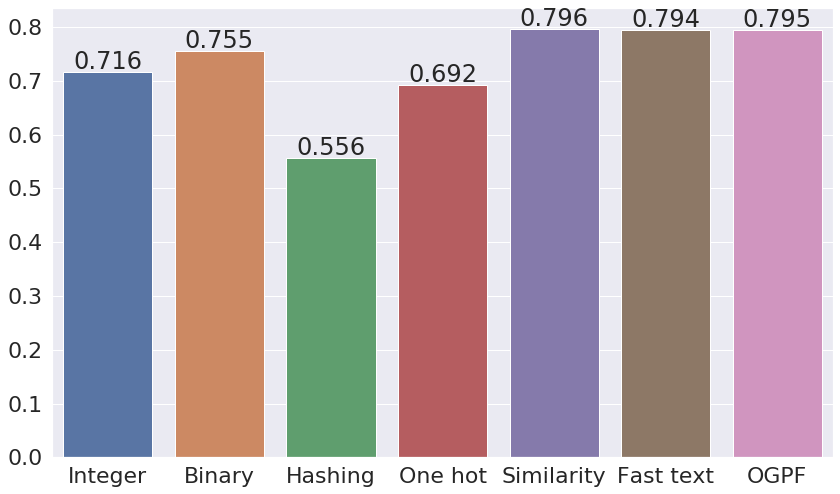

In [16]:
import seaborn as sns

if pipe_ft:
    x_axis = ['Integer', 'Binary', 'Hashing', 'One hot', 'Similarity', 'Fast text', 'OGPF']
    y_axis = [f1_ie, f1_be, f1_he, f1_ohe, f1_se, f1_ft, f1_ogpf]
else:
    x_axis = ['Integer', 'Binary', 'Hashing', 'One hot', 'Similarity', 'OGPF']
    y_axis = [f1_ie, f1_be, f1_he, f1_ohe, f1_se, f1_ogpf]

sns.set(rc={'figure.figsize':(14,8.27)})   
sns.set(font_scale=2)
g = sns.barplot(x=x_axis, y=y_axis)
for p in g.patches:
    g.annotate(format(p.get_height(), '.3f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10), textcoords = 'offset points')

## Conclusion

Encoding nominal categorical variables in unsupervised learning problems while optimizing the trade-off between performance and explainability is a challenging problem. We explored several techniques used in the literature for an example dataset evaluating the pros and cons of each. If the cardinality (number of levels) of nominal categories is less, then one hot encoding should be preferred as it preserves the distance between the categories. The interpretation of low and high cardinality depends on the domain but high cardinality would imply hundreds of unique category levels. If the cardinality is high, then we have to use the information present in the string of the nominal variable. Word based encoders like Similarity encoder and  online gamma poisson factorization encoder try to extract information from the n-grams (collection of characters) present in the strings. The evidence suggests that they increase the performance of the classifier indicating that they provide a meaningful representation. The online gamma factorization encoder also provides an interpretation of the reduced dimensional space which can be useful in the unsupervised tasks. 